# Technology focus: Visium HD

This notebook will present an overview of the plotting functionalities of the `spatialdata` framework, in the context of a Visium HD dataset.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

## Loading the data

A reader for Visium HD data is available in `spatialdata-io`. We used it to parse and convert to Zarr a [Visium HD dataset of a Mouse Small Intestine (FFPE)](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine).

We provide the already-converted Zarr data [available for download here](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_hd_3.0.0_io.zip).

Please download the data, rename the `.zarr` store to `visium_hd.zarr` and place it in the current folder (in alterantive you can use symlinks to make the data visible).

In [2]:
visium_hd_zarr_path = "./visium_hd.zarr"

A note on data loading. The data requires ~10 seconds to load because, while we support lazy representation of images, labels and points, the shapes geometries and the annotation tables are currently not represented lazily. This is one of the first spatial omics datasets which reaches a scale for which this is required. We will make a new release to allow for lazy representation also of these data types.

In [3]:
%%time
import spatialdata as sd

sdata = sd.read_zarr(visium_hd_zarr_path)
sdata

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


CPU times: user 12.5 s, sys: 1.59 s, total: 14.1 s
Wall time: 13.3 s


/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object with:
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_cytassist_image': SpatialImage[cyx] (3, 3000, 3200)
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': MultiscaleSpatialImage[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': SpatialImage[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': SpatialImage[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 2) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 2) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (91033, 2) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (5479660, 19059)
      ├── 'square_008um': AnnData (351817, 19059)
      └── 'square_016um': AnnData (91033, 19059)
with coordinate systems:
▸ 'downscaled

The datasets contains 1 large microscopy image, represented as a multiscale, chunked image; two explicit downscaled versions of it and one CytAssist image.

Also, the image dataset contains the data at the highest resolution (2µm bins), and 2 downsampled (binned) versions of it, which have respectively bin sizes of 8µm and 16µm.

In [4]:
# let's make the var names unique, this improves performance in accessing the tabular data
for table in sdata.tables.values():
    table.var_names_make_unique()

## Plotting the images

Let's visualize the images.

INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   


INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   


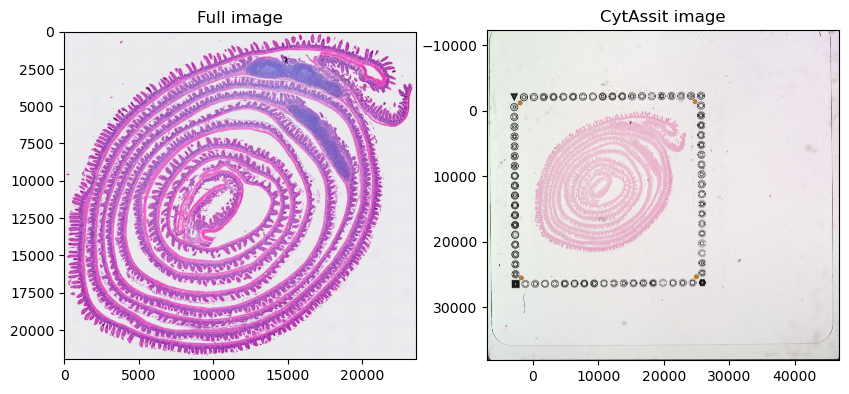

In [5]:
import matplotlib.pyplot as plt
import spatialdata_plot

axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_cytassist_image").pl.show(ax=axes[1], title="CytAssit image")

Let's plot the same range for the 2 images; to achieve this we first compute the extent of the first image with `spatialdata.get_extent()` and then crop the second data using the `spatialdata` query APIs.

Please note that setting the plotting lim (`ax.set_xlim()`, ...) after plotting may lead to lower image quality because the data is plotted at the optimal resolution for the full extent but then a portion of it is zoomed in.

In [6]:
from spatialdata import get_extent

data_extent = get_extent(sdata["Visium_HD_Mouse_Small_Intestine_full_image"], coordinate_system="global")
data_extent

{'y': (0.0, 21943.0), 'x': (0.0, 23618.0)}

In [7]:
from spatialdata import bounding_box_query

queried_cytassist = bounding_box_query(
    sdata["Visium_HD_Mouse_Small_Intestine_cytassist_image"],
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system="global",
)
sdata["queried_cytassist"] = queried_cytassist

INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   


INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   


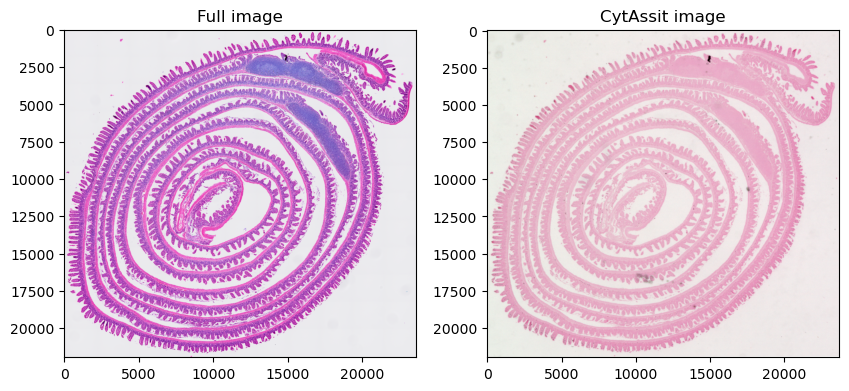

In [8]:
axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show(ax=axes[1], title="CytAssit image")

Let's focus the visualization on a smaller region, so we can appreciate better resolution of the first image. Here we create cropped version of the `SpatialData` objects on-the-fly using an anonymous function.

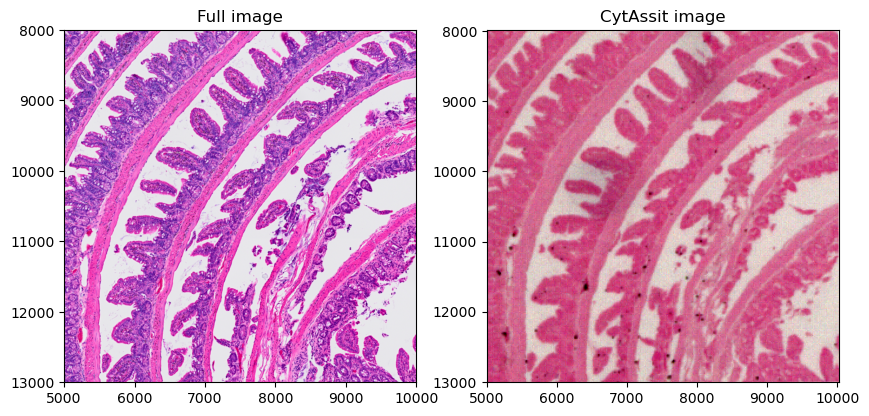

In [9]:
axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
crop0 = lambda x: bounding_box_query(
    x, min_coordinate=[5000, 8000], max_coordinate=[10000, 13000], axes=("x", "y"), target_coordinate_system="global"
)
crop0(sdata).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(
    ax=axes[0], title="Full image", coordinate_systems="global"
)
crop0(sdata).pl.render_images("queried_cytassist").pl.show(
    ax=axes[1], title="CytAssit image", coordinate_systems="global"
)

## Plotting the gene expression data

Let's plot the bins colored by gene expression. For the moment we will use the largest bin size. Later in the notebook we will make plots using the two smaller bin sizes on a cropped version of the data.

We are working on a new approach based on vector data rasterization that will improve plotting performance. We will update this notebook accordingly when it is ready.

CPU times: user 10.8 s, sys: 1.25 s, total: 12.1 s
Wall time: 12.6 s


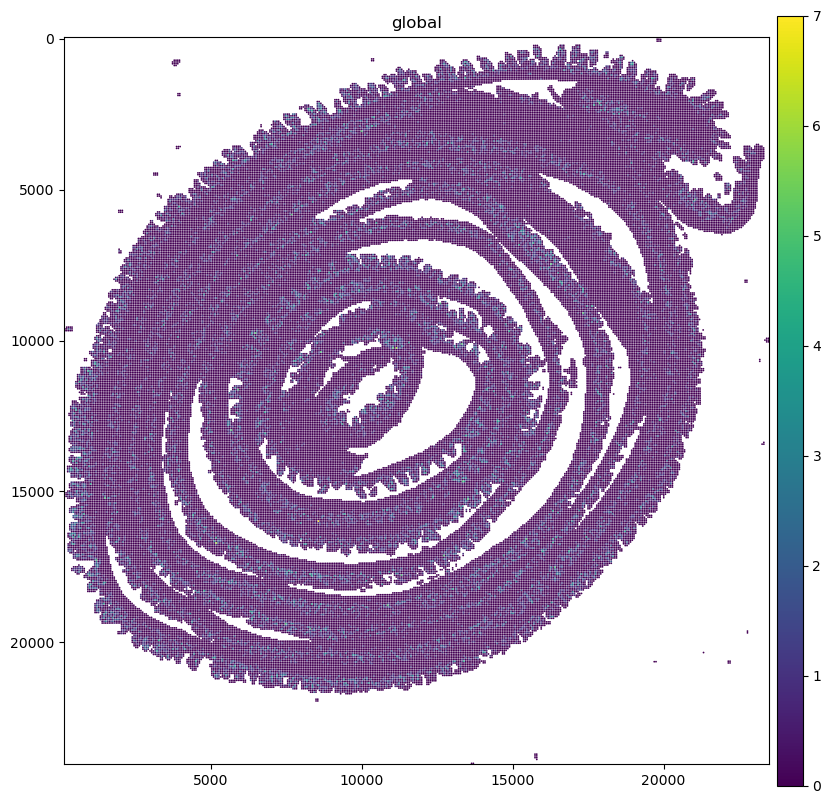

In [10]:
%%time
plt.figure(figsize=(10, 10))
ax = plt.gca()

gene_name = "AA986860"
sdata.pl.render_shapes("Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name).pl.show(
    coordinate_systems="global", ax=ax
)

Let's crop the data and make plots for all the bin sizes.

In [11]:
sdata_small = sdata.query.bounding_box(
    min_coordinate=[7000, 11000], max_coordinate=[10000, 14000], axes=("x", "y"), target_coordinate_system="global"
)

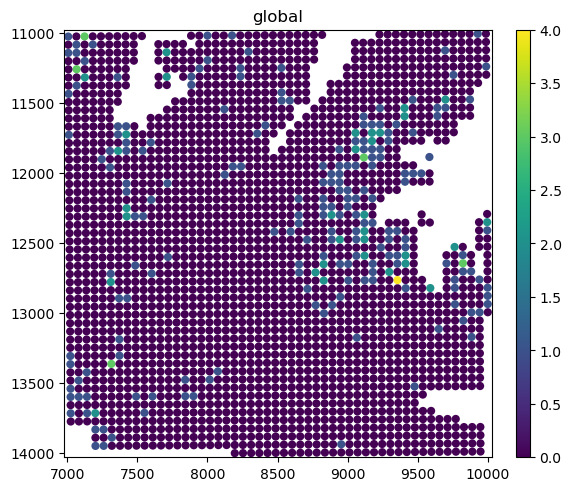

In [12]:
gene_name = "AA986860"
sdata_small.pl.render_shapes("Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name).pl.show(
    coordinate_systems="global"
)

The bins are represented as circles for performance reasons (`matplotlib` is efficient at both plotting circles and squares, but not `napari`). Let's quickly convert the circles to squares.

In [13]:
from geopandas import GeoDataFrame
from shapely import Point, Polygon
from spatialdata.models import ShapesModel
from spatialdata.transformations import get_transformation


def square_from_circle(point: Point, r: float) -> Polygon:
    x, y = point.xy
    x = x[0]
    y = y[0]
    global rr
    rr = r
    return Polygon([(x - r, y - r), (x - r, y + r), (x + r, y + r), (x + r, y - r)])


# an optimized and more complete version of this function will be available in the spatialdata library in a next release
def squares_from_circles(gdf: GeoDataFrame) -> GeoDataFrame:
    geoseries = gdf[["geometry", "radius"]].apply(lambda row: square_from_circle(row[0], row[1]), axis=1)
    squares = GeoDataFrame(geometry=geoseries)
    transformations = get_transformation(gdf, get_all=True)
    return ShapesModel.parse(squares, transformations=transformations)

In [14]:
for name in list(sdata_small.shapes.keys()):
    squares = squares_from_circles(sdata_small[name])
    sdata_small[name] = squares

/tmp/ipykernel_5251/2051837744.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geoseries = gdf[["geometry", "radius"]].apply(lambda row: square_from_circle(row[0], row[1]), axis=1)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:92: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_002um` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/tmp/ipykernel_5251/2051837744.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geoseries = gdf[["geometry", "radius"]].apply(lambda row: square_from_circle(row[0], row[1]), axis=1)
/Users/macbook/

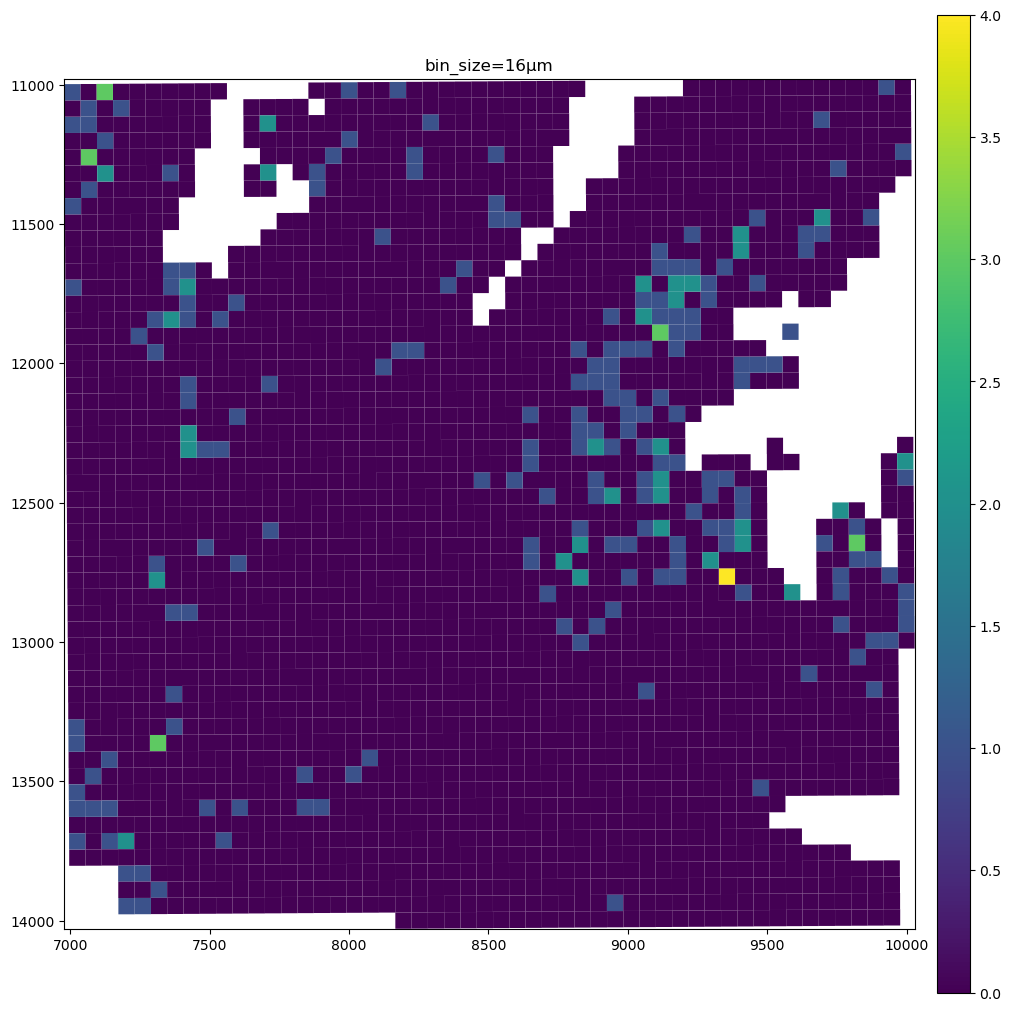

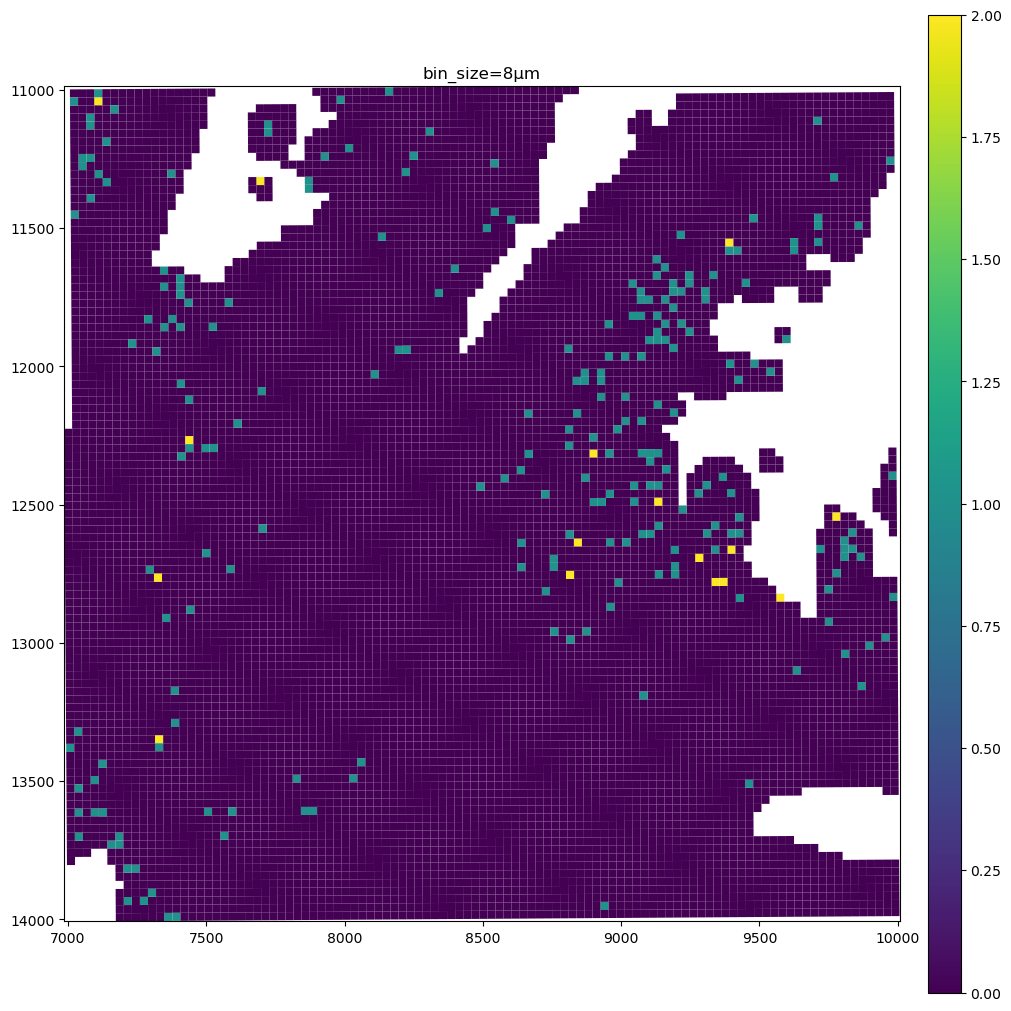

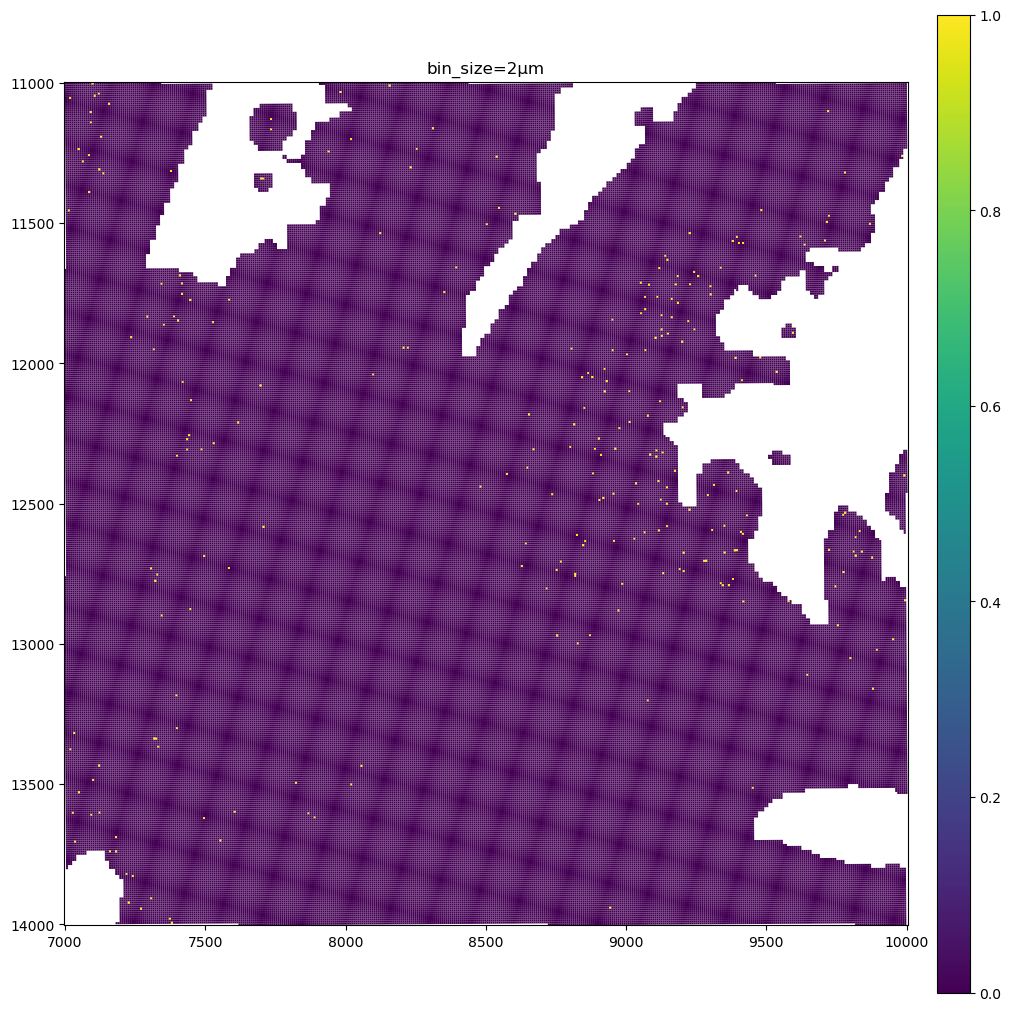

In [15]:
gene_name = "AA986860"

for bin_size in [16, 8, 2]:
    sdata_small.pl.render_shapes(f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um", color=gene_name).pl.show(
        coordinate_systems="global", title=f"bin_size={bin_size}µm", figsize=(10, 10)
    )

The data present a lot of sparsity, let's remake the plots above by visualizing only the non-zero entries, and using the full resolution image as a background.

We will do this by modifying the viridis colormap so that 0 is plotted as transparent. Let' also truncate the viridis colormap so that the highest value is colored as green and not yellow, since green has a better contrast against the pink of the H&E microscopy image.

In [16]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# modify the viridis colormap, so that the top color is a green (better visible on the H&E pink), and such that
# the value 0 leads to a transparent color
viridis = cm.get_cmap("viridis", 256)
# using 0.8 instead of 1.0 truncates the colormap
colors = viridis(np.linspace(0, 0.8, 256))
# set the color of zero to be transparent
colors[0, :] = [1.0, 1.0, 1.0, 0.0]

new_cmap = LinearSegmentedColormap.from_list("truncated_viridis", colors)

/tmp/ipykernel_5251/4048039272.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap("viridis", 256)


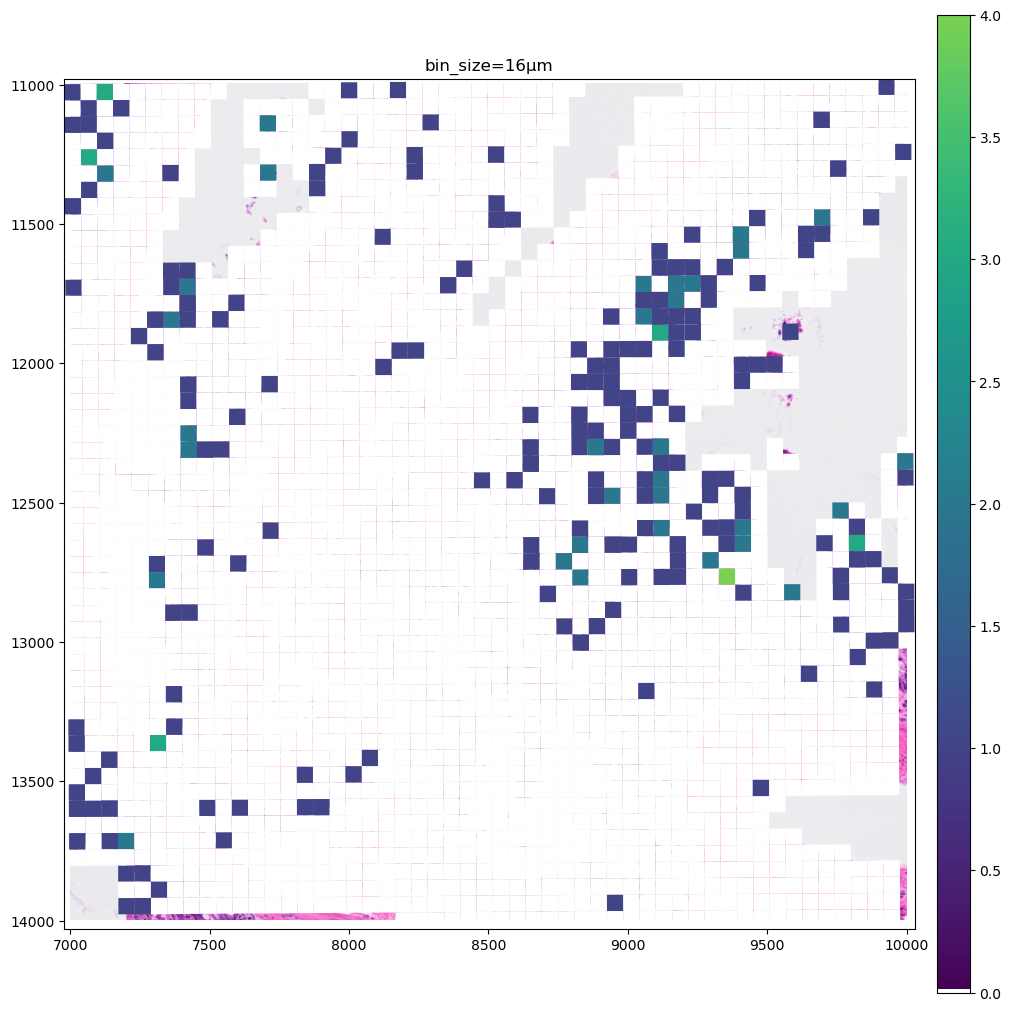

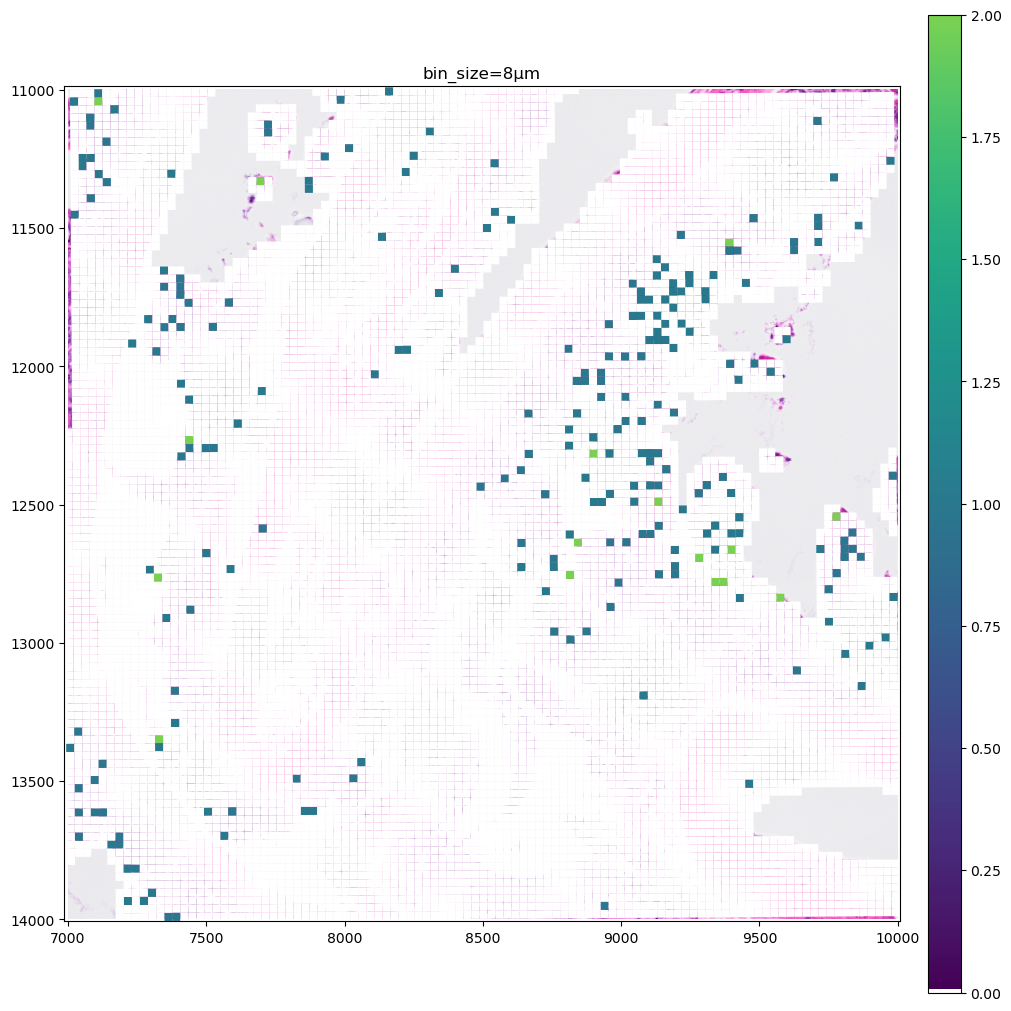

In [17]:
gene_name = "AA986860"

for bin_size in [16, 8]:
    sdata_small.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um", color=gene_name, cmap=new_cmap
    ).pl.show(coordinate_systems="global", title=f"bin_size={bin_size}µm", figsize=(10, 10))

Let's make a zoomed version of the plot for the 2µm bins, to better visiualize them.

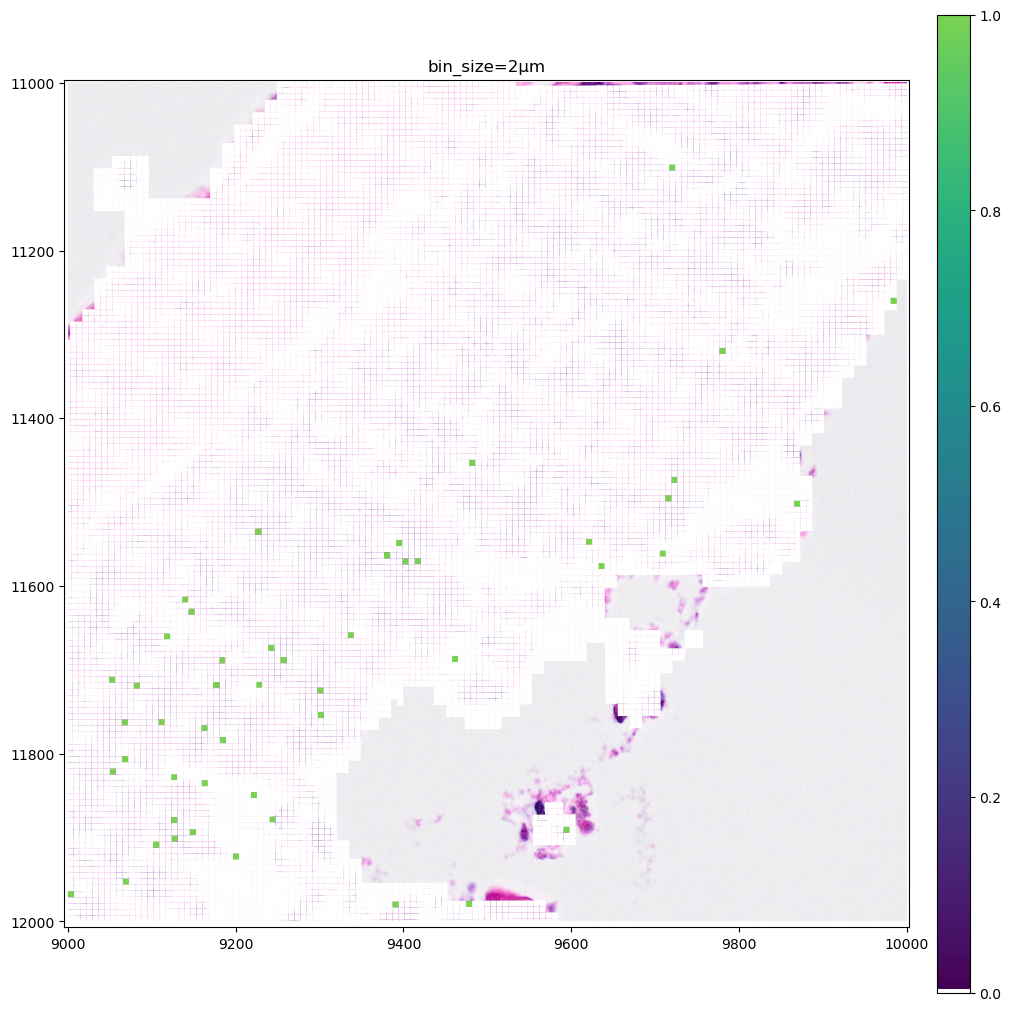

In [18]:
crop1 = lambda x: bounding_box_query(
    x, min_coordinate=[9000, 11000], max_coordinate=[10000, 12000], axes=("x", "y"), target_coordinate_system="global"
)
crop1(sdata_small).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_002um", color=gene_name, cmap=new_cmap
).pl.show(coordinate_systems="global", title=f"bin_size=2µm", figsize=(10, 10))

As you can see the 8µm bins are convenient for looking at gene expression distribution from a broad perspective (same for the 16µm bins, where some resolution can be sacrificed in exchange for a faster visualization). On the other hand, the 2µm bins allow to precisely locate the expressed genes in the tissue.

## Plotting clusters

Let's now color the 16µm bins by cluster identity. Let's reuse the clusters `gene_expression_graphclust` computed from 10x Genomics and available together with the raw data from the 10x Genomics website.

In [19]:
import os
from tempfile import TemporaryDirectory

import pandas as pd
import requests

# For convenience we rehost the single file containing the clusters we are interested in.
# Let's download it in a temporary directory and read it in a pandas DataFrame. The file is 2 MB.
clusters_file_url = "https://s3.embl.de/spatialdata/misc/visium_hd_mouse_intestine_16um_graphclust.csv"

with TemporaryDirectory() as tmpdir:
    path = os.path.join(tmpdir, "data.csv")
    response = requests.get(clusters_file_url)
    with open(path, "wb") as f:
        f.write(response.content)
    df = pd.read_csv(path)

In [20]:
df.head(3)

Barcode  Cluster
0  s_016um_00144_00175-1        3
1  s_016um_00145_00029-1        7
2  s_016um_00165_00109-1        8

In [21]:
# let's convert the Cluster dtype from int64 to categorical since later we want the plots to use a categorical colormap
df["Cluster"] = df["Cluster"].astype("category")
df.set_index("Barcode", inplace=True)

In [22]:
sdata["square_016um"].obs.head(3)

in_tissue  array_row  array_col  location_id  \
s_016um_00144_00175-1          1        144        175            0   
s_016um_00145_00029-1          1        145         29            1   
s_016um_00165_00109-1          1        165        109            2   

                                                             region  
s_016um_00144_00175-1  Visium_HD_Mouse_Small_Intestine_square_016um  
s_016um_00145_00029-1  Visium_HD_Mouse_Small_Intestine_square_016um  
s_016um_00165_00109-1  Visium_HD_Mouse_Small_Intestine_square_016um

Let's merge the data.

In [23]:
sdata["square_016um"].obs["Cluster"] = df["Cluster"]

Let's plot the clusters on one of the data crops we used before.

In [24]:
# let convert circles to squares before making the plot
name = "Visium_HD_Mouse_Small_Intestine_square_016um"
sdata[name] = squares_from_circles(sdata[name])

/tmp/ipykernel_5251/2051837744.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geoseries = gdf[["geometry", "radius"]].apply(lambda row: square_from_circle(row[0], row[1]), axis=1)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:92: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_016um` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:709: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


CPU times: user 1.79 s, sys: 139 ms, total: 1.92 s
Wall time: 1.9 s


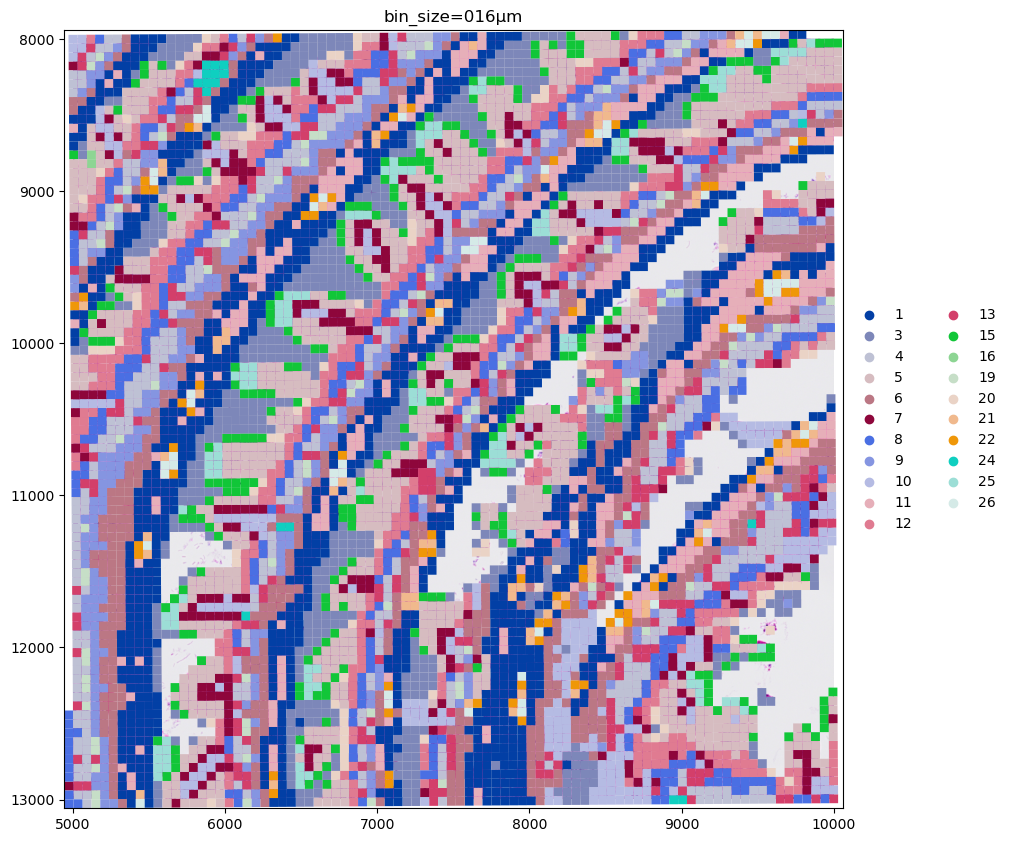

In [25]:
%%time
crop0(sdata).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um", color="Cluster"
).pl.show(coordinate_systems="global", title=f"bin_size=016µm", figsize=(10, 10))

To conclude the example here is a screenshot of `napari-spatialdata` used to visualize the data on 16µm bins. Currently `napari`'s performance is not optimized for the visualization of large collections of polygonal data (this warning is displayed as a tooltip is the user hovers the mouse above the warning symbols in the bottom left). We are therefore working on a rasterization-based approach to overcome these limitations and enable the visualization of Visium HD data with napari also for smaller bin sizes.

![image.png](attachments/napari_visium_hd.png)